In [1]:
RANDOM_STATE = 42

In [2]:
from duplebalance import DupleBalanceClassifier
from duplebalance.baselines import ResampleClassifier
from duplebalance.base import sort_dict_by_key

import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [3]:
X, y = make_classification(n_classes=5, class_sep=1, # 5-class
    weights=[0.05, 0.05, 0.15, 0.25, 0.5], n_informative=3, n_redundant=1, flip_y=0,
    n_features=20, n_clusters_per_class=1, n_samples=2000, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

origin_distr = sort_dict_by_key(Counter(y_train))
test_distr = sort_dict_by_key(Counter(y_test))
print('Original training dataset shape %s' % origin_distr)
print('Original test dataset shape %s' % test_distr)

Original training dataset shape {0: 52, 1: 48, 2: 145, 3: 268, 4: 487}
Original test dataset shape {0: 48, 1: 52, 2: 155, 3: 232, 4: 513}


In [4]:
n_estimators_list = [1, 3, 5, 10, 20]

ensemble_init_kwargs = {
    'random_state': RANDOM_STATE,
}

eval_kwargs = {'average': 'macro', 'multi_class': 'ovo'}

BASECLF = DecisionTreeClassifier()

# Initialize results list
all_results = []

for n_estimators in n_estimators_list:
    # Train DuBE classifiers
    clf = DupleBalanceClassifier(
        base_estimator=BASECLF,
        n_estimators=n_estimators,
        **ensemble_init_kwargs
    ).fit(
        X_train, y_train,
        resampling_target='under',
        resampling_strategy='shem',
        perturb_alpha=.5,
        sample_weight=None,
        eval_datasets={'test': (X_test, y_test)},
        train_verbose=False,
    )
    y_pred_proba = clf.predict_proba(X_test)
    score = roc_auc_score(y_test, y_pred_proba, **eval_kwargs)
    print ("DuBE {:<2d} | Balanced AUROC: {:.3f} | #Training Samples: {:d}".format(
        n_estimators, score, sum(clf.estimators_n_training_samples_)
        ))
    all_results.append(
        ['DuBE', score, sum(clf.estimators_n_training_samples_)]
    )

DuBE 1  | Balanced AUROC: 0.869 | #Training Samples: 240
DuBE 3  | Balanced AUROC: 0.945 | #Training Samples: 720
DuBE 5  | Balanced AUROC: 0.965 | #Training Samples: 1200
DuBE 10 | Balanced AUROC: 0.977 | #Training Samples: 2400
DuBE 20 | Balanced AUROC: 0.984 | #Training Samples: 4800


In [5]:
from imblearn.under_sampling import *
from imblearn.over_sampling import *

resamp_init_kwargs = {'random_state': 42}

samplers = {
    'No-resampling': None,
    'RUS': RandomUnderSampler(**resamp_init_kwargs),
    'TomekLinks': TomekLinks(),
    'NearMiss': NearMiss(),
    'Condense': CondensedNearestNeighbour(**resamp_init_kwargs),
    'ROS': RandomOverSampler(**resamp_init_kwargs),
    'SMOTE': SMOTE(**resamp_init_kwargs),
    'ADASYN': ADASYN(**resamp_init_kwargs),
    'BorderSMOTE': BorderlineSMOTE(**resamp_init_kwargs),
}

for sampler_name, sampler in samplers.items():
    clf = ResampleClassifier(
        base_estimator=BASECLF,
        sampler=sampler
    ).fit(X_train, y_train)
    y_pred_proba = clf.predict_proba(X_test)
    score = roc_auc_score(y_test, y_pred_proba, **eval_kwargs)
    print (sampler_name, score, clf.n_training_samples_)
    
    all_results.append(
        [sampler_name, score, clf.n_training_samples_]
    )

No-resampling 0.8913552039669878 1000
RUS 0.8641540035341079 240
TomekLinks 0.8761283042557741 920
NearMiss 0.8329180280158341 240
Condense 0.814043404729785 227
ROS 0.8616460077578243 2435
SMOTE 0.8638821728371153 2435
ADASYN 0.8675704210214412 2390
BorderSMOTE 0.8294323291248787 2435


<AxesSubplot:title={'center':'DuBE versus Resampling Baselines'}, xlabel='#Training Samples', ylabel='AUROC (macro)'>

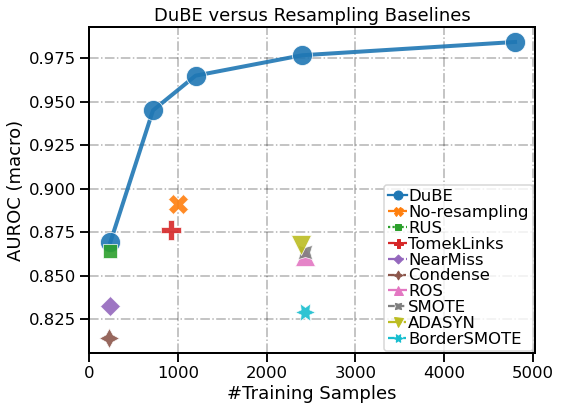

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

def plot_results_comp(data_vis, x, y, title, figsize=(8,6)):
    fig = plt.figure(figsize=figsize)
    ax = sns.lineplot(
        data=data_vis, x=x, y=y, hue='Method', style='Method',
        markers=True, err_style='bars', linewidth=4, markersize=20, alpha=0.9
    )
    for position, spine in ax.spines.items():
        spine.set_color('black')
        spine.set_linewidth(2)
    ax.grid(color = 'black', linestyle='-.', alpha=0.3)
    ax.set_ylabel('AUROC (macro)')
    ax.set_title(title)
    ax.legend(
        title='',
        borderpad=0.25,
        columnspacing=0.05,
        borderaxespad=0.15,
        handletextpad=0.05,
        labelspacing=0.05,
        handlelength=1.2,
        )
    return ax

all_results_columns = ['Method', 'AUROC (macro)', '#Training Samples']
data_vis = pd.DataFrame(all_results, columns=all_results_columns)
plot_results_comp(data_vis, x='#Training Samples', y='AUROC (macro)',
                  title='DuBE versus Resampling Baselines')